In [1]:
import  xihua

import random
import tensorflow
import matplotlib.pyplot as plt
import pickle
import  xlrd
import os
import numpy as np
from PIL import Image,ImageFont,ImageDraw
import xlwt
import  cv2
import  shutil
from ImageUtil import  *


In [2]:
#得到汉字和字符的映射
def get_dict(path):
    """
    :param path:存储汉字的excel绝对路径，一列存 
    :return: id2word，word2id
    """
    table = xlrd.open_workbook(path)
    sheet = table.sheet_by_index(0)
    id2word = {}
    word2id = {}
    for i in range(sheet.nrows):
        word = sheet.row_values(i)[0]
        id2word[i] = word
        word2id[word] = i
# print(word, type(word))
    return id2word,word2id

table_path = r'汉字编码字符集一级字库3755个（一列）.xls'
id2word, word2id = get_dict(table_path)
with open(r"Data/id2word.pkl","wb") as f:
    pickle.dump(id2word, f)
with open(r"Data/word2id.pkl","wb") as f:
    pickle.dump(word2id, f)

魑 0


D:\OneDrive - stu.csust.edu.cn\code\python\毕设\xihua.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
  M = image[i,j-1]+image[i,j]+image[i,j+1] if 0<j<w-1 else 1
D:\OneDrive - stu.csust.edu.cn\code\python\毕设\xihua.py:41: RuntimeWarning: overflow encountered in ubyte_scalars
  M = image[i-1,j]+image[i,j]+image[i+1,j] if 0<i<h-1 else 1


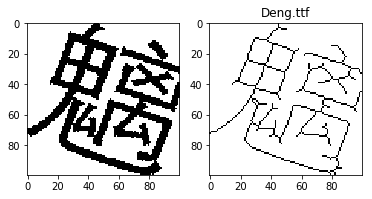

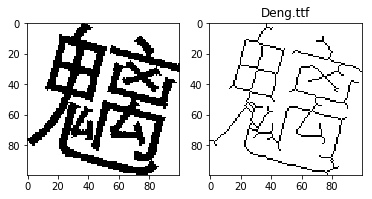

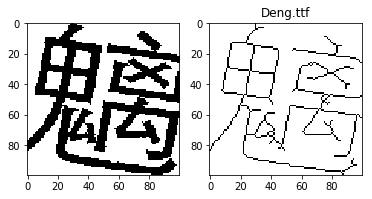

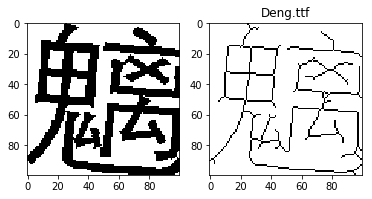

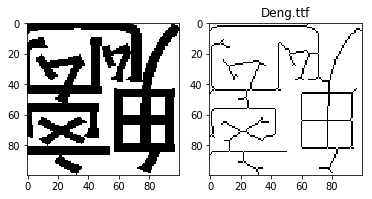

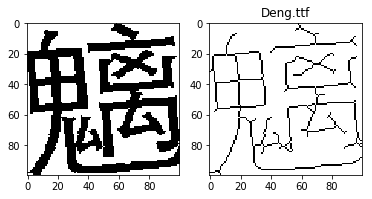

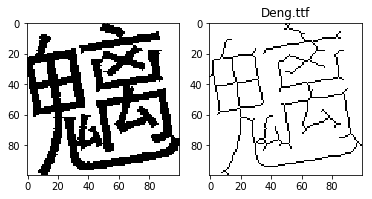

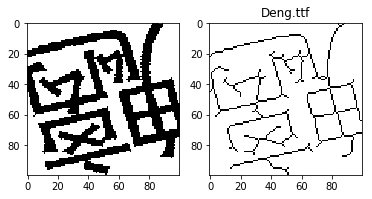

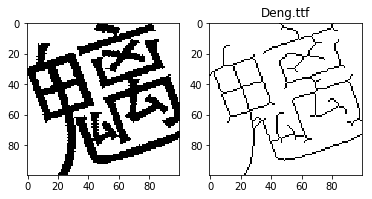

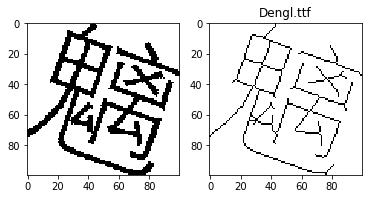

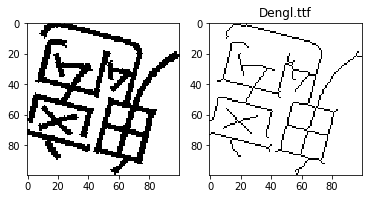

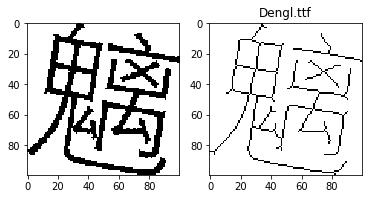

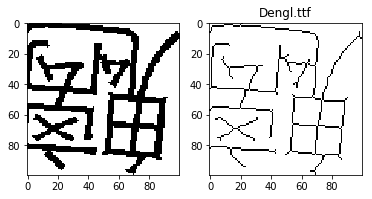

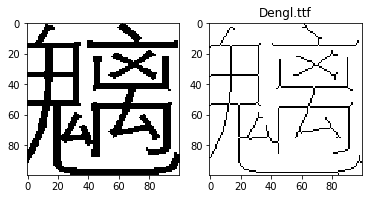

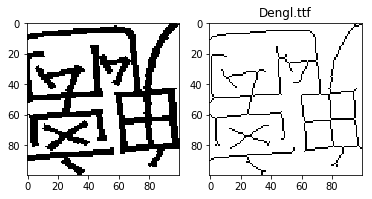

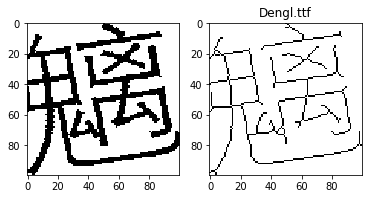

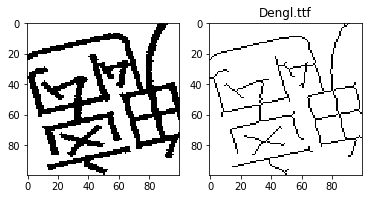

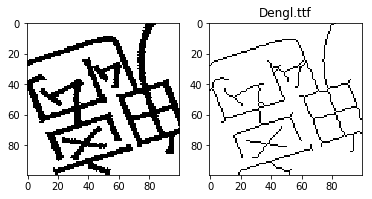

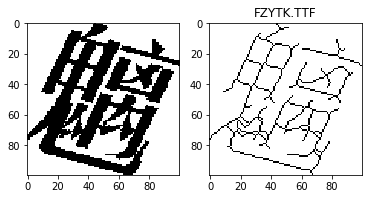

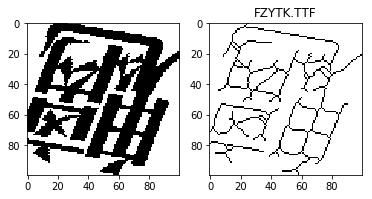

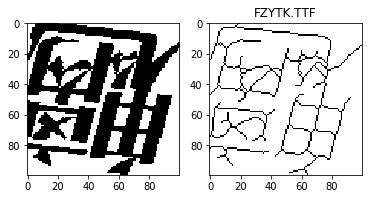

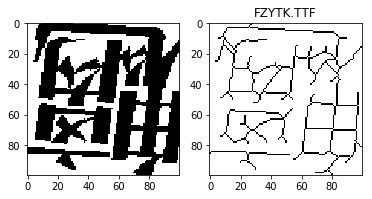

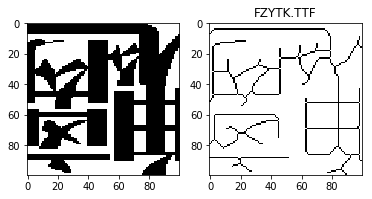

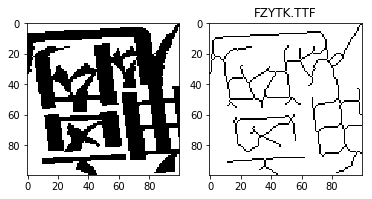

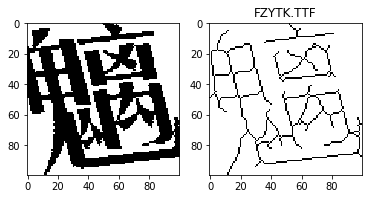

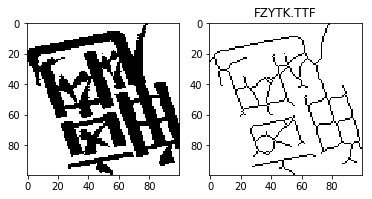

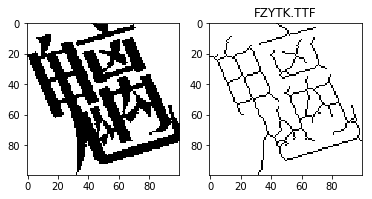

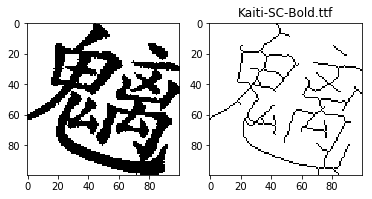

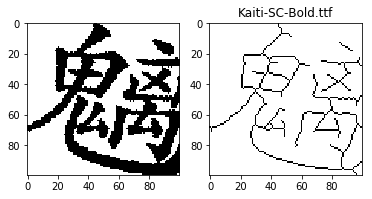

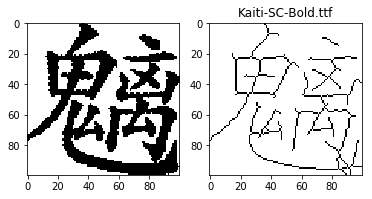

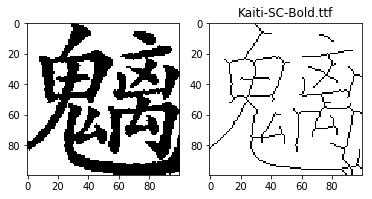

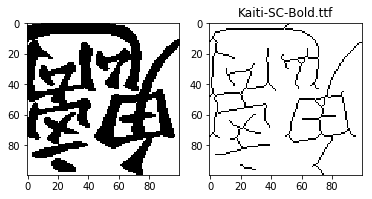

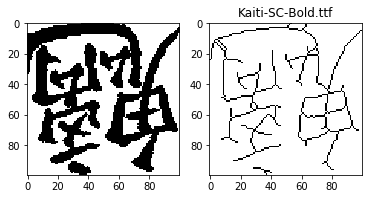

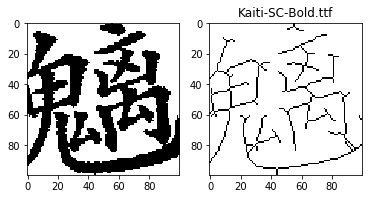

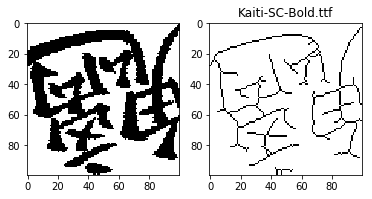

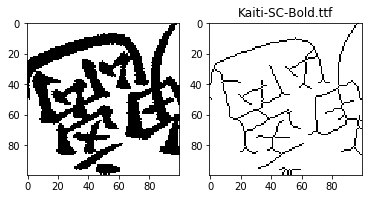

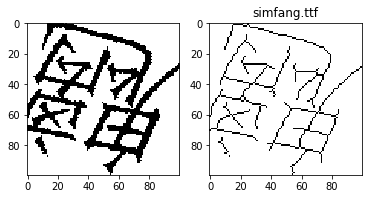

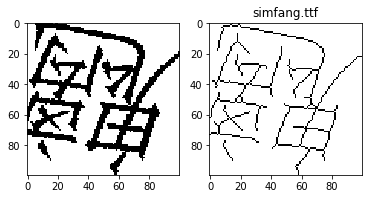

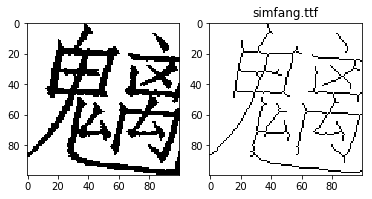

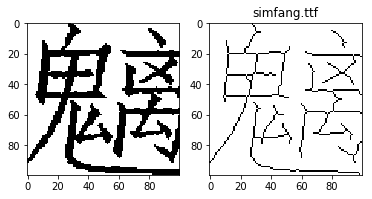

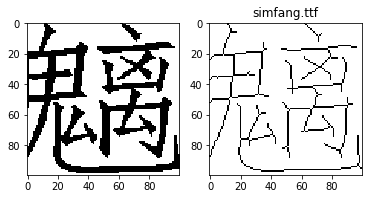

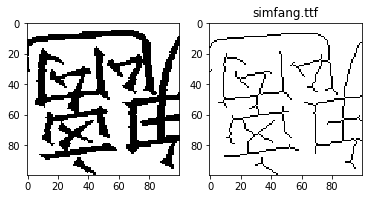

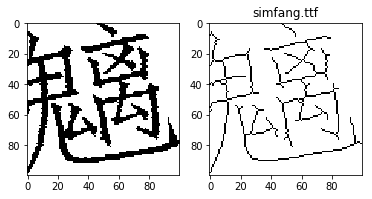

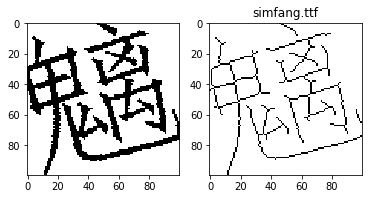

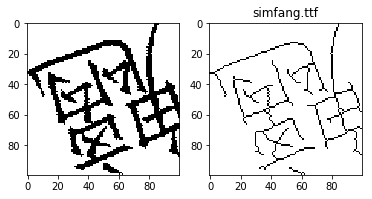

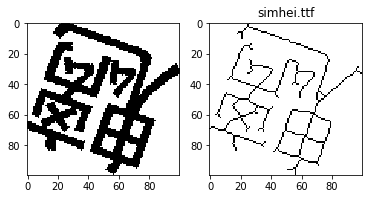

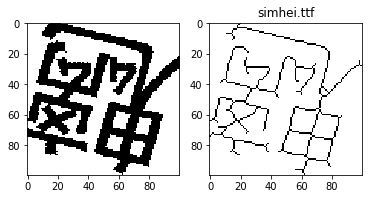

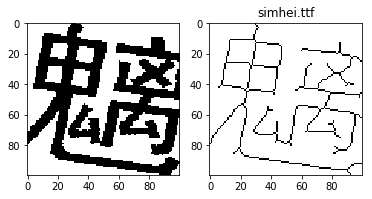

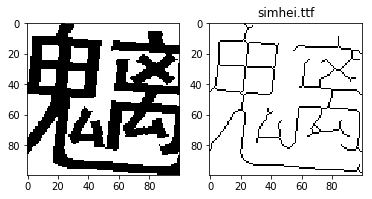

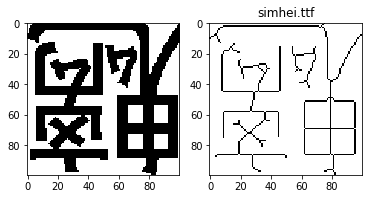

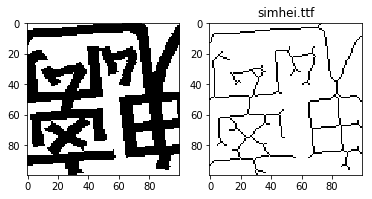

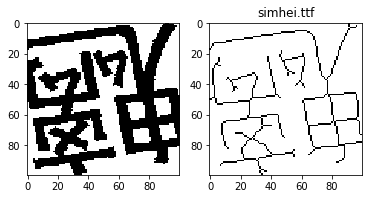

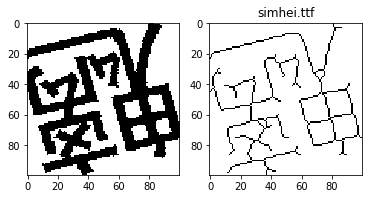

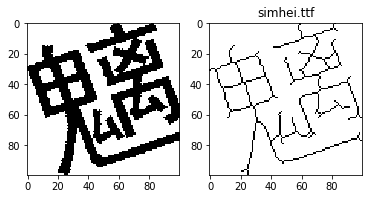

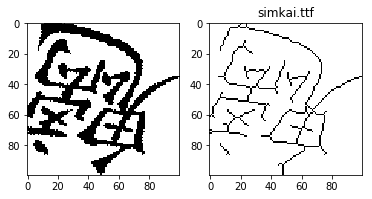

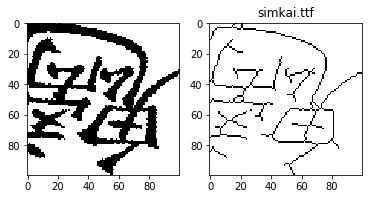

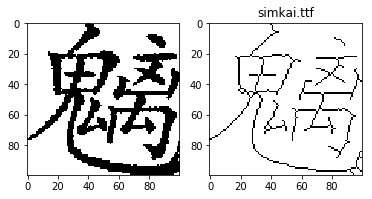

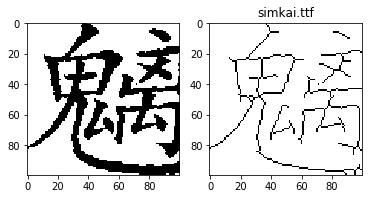

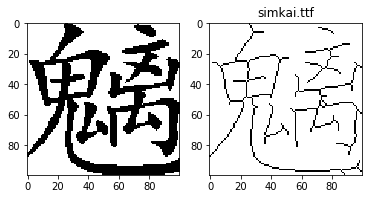

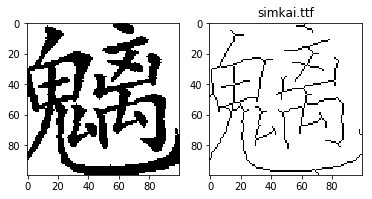

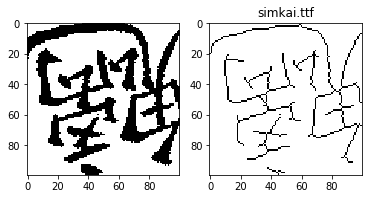

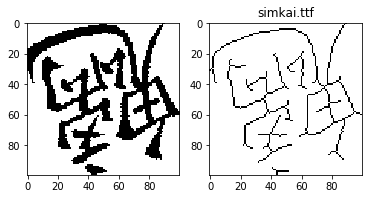

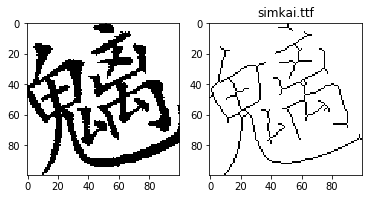

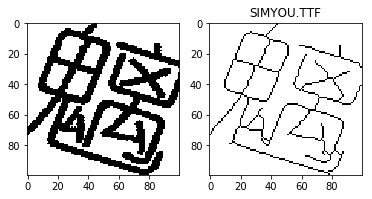

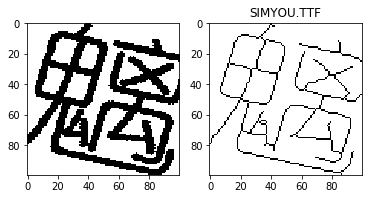

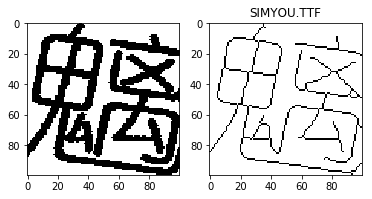

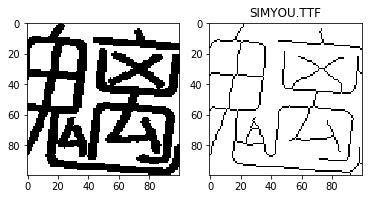

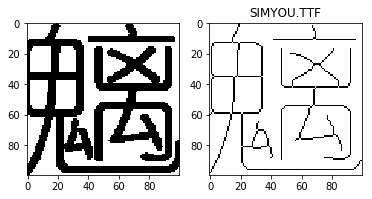

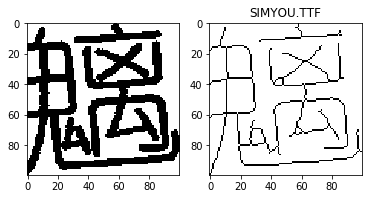

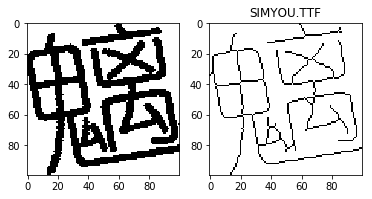

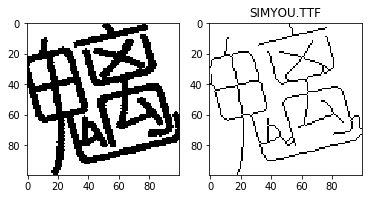

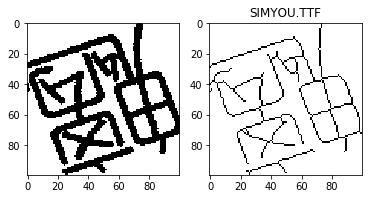

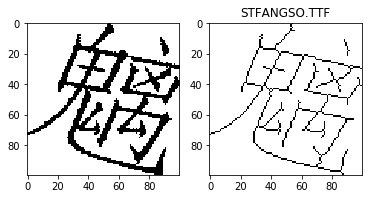

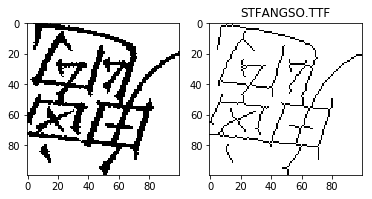

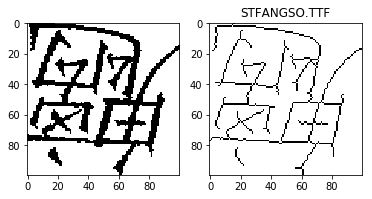

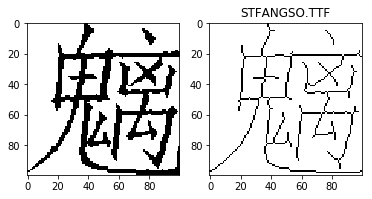

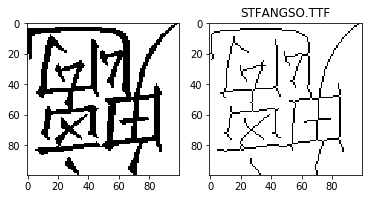

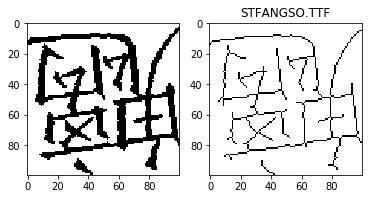

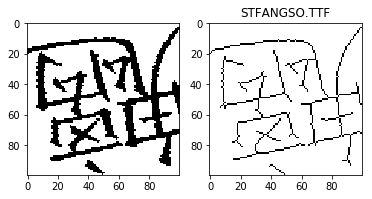

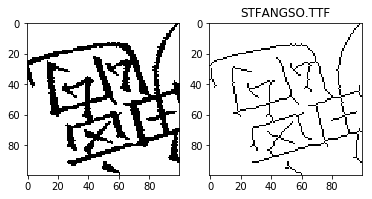

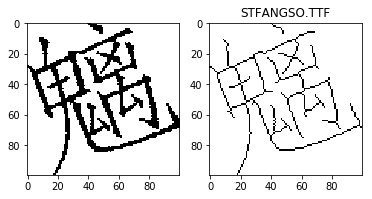

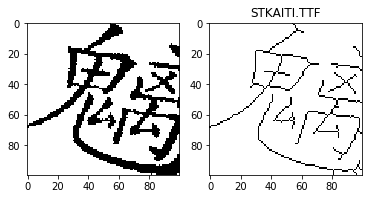

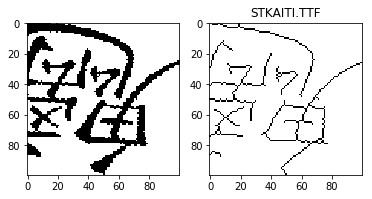

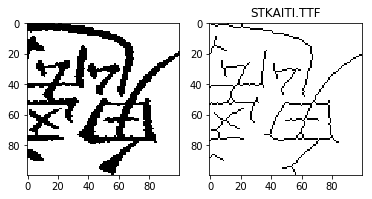

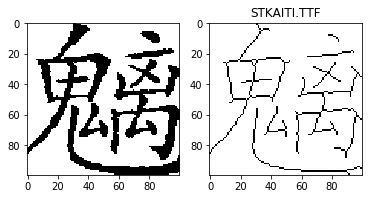

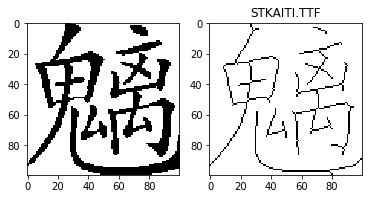

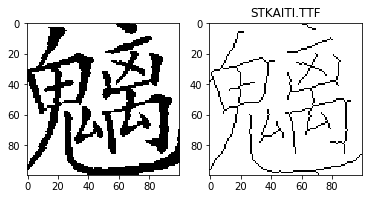

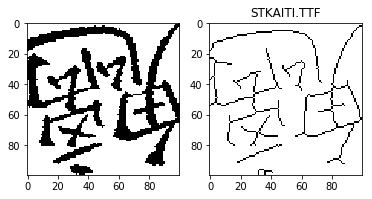

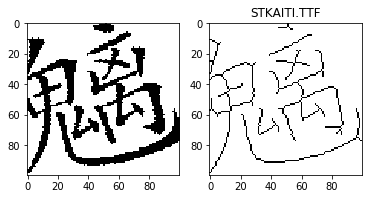

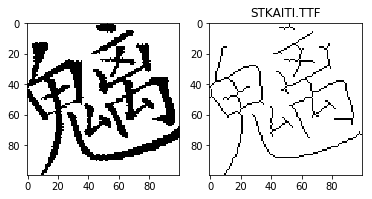

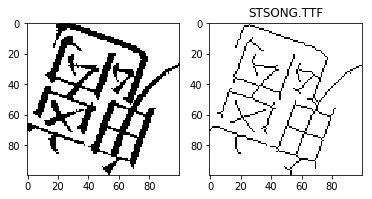

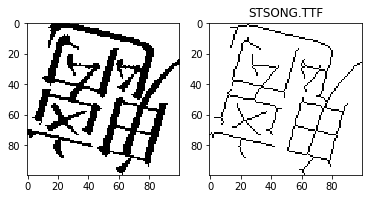

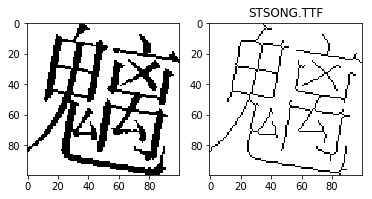

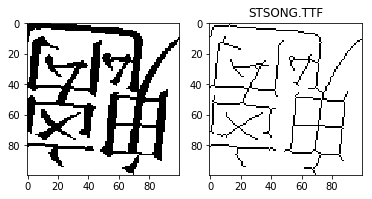

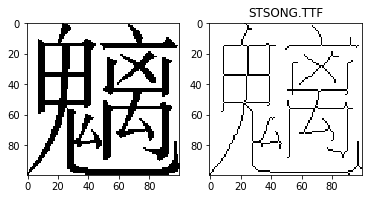

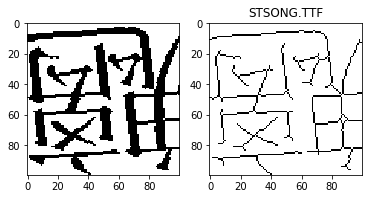

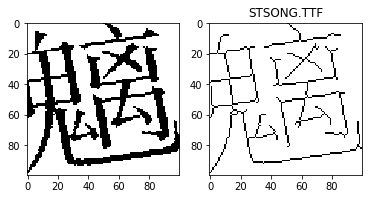

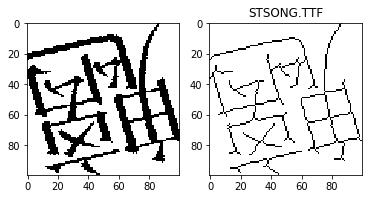

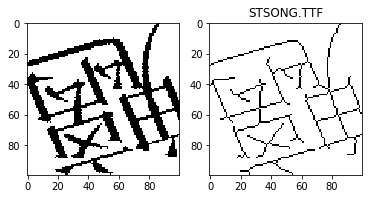

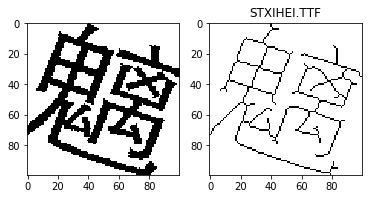

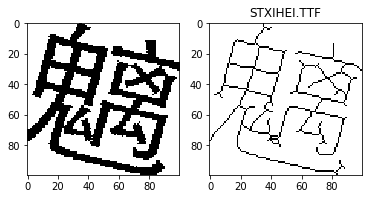

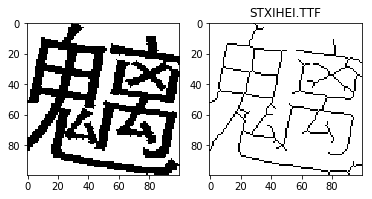

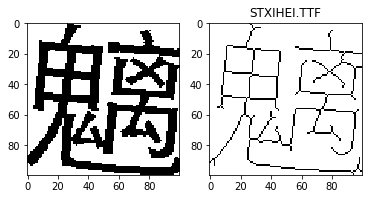

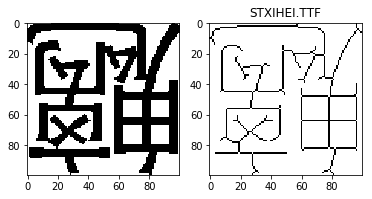

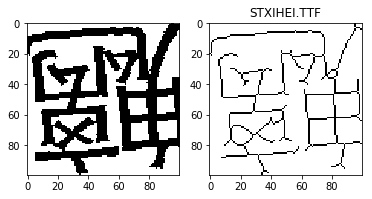

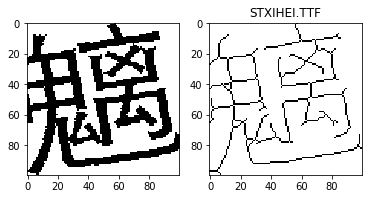

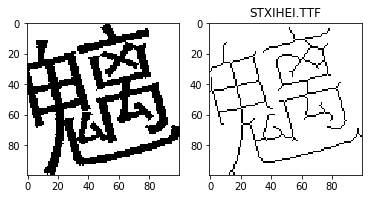

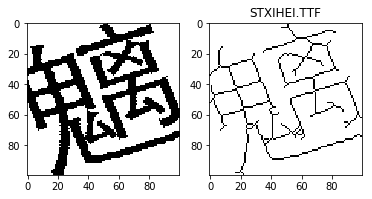

In [3]:
#得到初始数据集
class Font2Img(object):
    """
    
    """
    def __init__(self,
                 width,
                 height,
                 ):
        self.width = width
        self.height = height
    
    def get_image(self,font_path, word, rotate, crop,is_reversed ):
        """
        :param font_path: str,字体文件绝对路径 
        :param word: str,需要转化为图像的一个汉字
        :return: narray,size=(height,width),字体图像
        """
        #白色背景
        y=1
        img = Image.new("RGB", (self.width+100, self.height+100), "white")
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font_path, int(self.width+50))
        draw.fontmode = "1"
        #黑色字体
        draw.text((0, 0), word,(0,0,0),font = font)   
        img = img.rotate(rotate,  expand= 1, fillcolor="white")
        # print(img.size, type(img))
        img = np.asarray(img, dtype='uint8')[:,:,0]
        # plt.imshow(img, "gray")
        # plt.show()
        img = ImageProcessing.crop_margin(img,crop)
        img = cv2.resize(img,(self.height,self.width),Image.ANTIALIAS)
        # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
        th,img= cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        if is_reversed:
            img = img[::-1,::-1]
        return img 
    
        
def get_data(data_dir, width, height, Rotate, Rotate_step, test_ratio, crop,reversed_ratio,is_aug=0):
    id2word = {}
    word2id = {}
    with open(r"Data/id2word.pkl","rb") as f:
        id2word = pickle.load(f)
    with open(r"Data/word2id.pkl","rb") as f:
        word2id = pickle.load(f)
        
    # for item in 
    train_dir =os.path.join(data_dir, 'train') 
    test_dir = os.path.join(data_dir, 'test')
    for word, id in (('魑', 0),):# word2id.items():
        print(word, id)
        image_list = []
        font2img = Font2Img(width, height)
        for font_name in os.listdir(r"./Fonts")[:]:    
            # print(font_name)
            font_path = os.path.join(r"./Fonts",font_name)
            for rotate in range(-Rotate, Rotate+1, Rotate_step):
                is_reversed = random.random()<reversed_ratio
                img = font2img.get_image(font_path, word, rotate,crop,is_reversed)
                image_list.append((img,is_reversed))
                aug_img = None
                flag = None
                if is_aug :
                    rand = random.random()
                    if rand < 0.25:
                        aug_img = ImageProcessing.dilate(img,3)
                        flag =1
                    elif rand < 0.5:
                        aug_img = ImageProcessing.erode(img,3)
                        flag =2
                    elif rand < 0.75:
                        aug_img = ImageProcessing.closing(img,3)
                        flag =3
                    else:
                        aug_img = ImageProcessing.opening(img,3)
                        flag =4
                    image_list.append((aug_img,is_reversed))
                fig,ax = plt.subplots(1,2)
                ax[0].imshow(img,cmap="gray")
                # ax[1].imshow(aug_img,cmap="gray")
                ax[1].imshow(xihua.XiHua.Xihua(img),cmap="gray")
                # ax[3].imshow(xihua.Xihua(aug_img,xihua.array),cmap="gray")

                plt.title(font_name)
                plt.show()
        # test_num = len(image_list) * test_ratio 
        # np.random.shuffle(image_list)
        # count = 0
        # for i in range(len(image_list)):
        #    img = image_list[i][0] 
        #    is_reversed = image_list[i][1]
        #    if count < test_num:
        #        word_dir =os.path.join(test_dir,'%0.5d'%id) 
        #    else:
        #        word_dir =os.path.join(train_dir,'%0.5d'%id)
        # 
        #    if not os.path.isdir(word_dir): 
        #       os.makedirs(word_dir)
        #    path_image = os.path.join(word_dir, '%d %d.png'% (count,is_reversed))
        #    cv2.imwrite(path_image, img)
        #    count +=1
            
if __name__ =="__main__":
    width = 100
    height = 100
    Rotate = 20
    Rotate_step = 5 
    test_ratio = 0.02
    crop = 15# 字左右随机裁剪0-15个像素
    reversed_ratio = 0.4
    data_dir = r'kNNData'
    get_data(data_dir, width, height, Rotate, Rotate_step, test_ratio, crop,reversed_ratio, is_aug=False)

In [14]:
a =np.array([1,2])
b = []
b.append(a)
b.append(a)
print(b)
a[1] = 3
print(b)


[array([1, 2]), array([1, 2])]
[array([1, 3]), array([1, 3])]
